# Install Required Libraries

In [ ]:
## Step 1: Install Required Libraries
# In Colab, you can uncomment the lines below if needed
# !pip install pandas numpy scikit-learn tensorflow keras matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Read in the Data

In [ ]:
## Step 2: Read in the Data
# Define file path (ensure this is correctly set for your Colab environment)
file_path = "data_final.csv"
df = pd.read_csv(file_path)

## Explore the Data (Optional)

Used to review the raw data prior to any preprocessing

In [ ]:
# Display the first few rows to confirm data is loaded
print("Dataset Head:")
print(df.head())

Dataset Head:
    bill_id readable_bill_id Bill Chamber Bill Type  Bill Number  \
0  2023_H_2              HB2            H         B            2   
1  2023_H_3             HJR3            H        JR            3   
2  2023_S_1              SR1            S         R            1   
3  2023_S_2              SB2            S         B            2   
4  2021_H_2              HB2            H         B            2   

  Local or Public Bill  Vote Type  nAppropriations  nFiscalImpact  \
0                    P          0                0              0   
1                    P          0                0              0   
2                    P          0                0              0   
3                    P          0                0              0   
4                    P          0                0              0   

   nUncodified  ...  cosponsor_count  dem_sponsor_count  rep_sponsor_count  \
0            1  ...              2.0                0.0               18.0   
1     

In [ ]:
# Display summary statistics for numerical and categorical variables
print("\nNumerical Summary Statistics:")
print(df.describe())

print("\nCategorical Summary Statistics:")
print(df.describe(include="object"))


Numerical Summary Statistics:
        Bill Number     Vote Type  nAppropriations  nFiscalImpact  \
count  15185.000000  15185.000000     15185.000000   15185.000000   
mean     515.476457      0.012117         0.164373       0.009088   
std      323.144710      0.109413         0.370626       0.094900   
min        1.000000      0.000000         0.000000       0.000000   
25%      234.000000      0.000000         0.000000       0.000000   
50%      499.000000      0.000000         0.000000       0.000000   
75%      770.000000      0.000000         0.000000       0.000000   
max     1277.000000      1.000000         1.000000       1.000000   

        nUncodified  nConstitution      nStudies     nRollCall  Short Title  \
count  15185.000000   15185.000000  15185.000000  15185.000000          0.0   
mean       0.058874       0.026276      0.079881      0.043530          NaN   
std        0.235396       0.159960      0.271119      0.204053          NaN   
min        0.000000       0.000

In [ ]:
# Count missing values per column
missing_values = df.isnull().sum()
print("\nMissing Values Count:")
print(missing_values[missing_values > 0])


Missing Values Count:
Bill Type                4355
Short Title             15185
sSummary                    7
primary_sponsor_name     2434
status_date               241
last_action_date          256
dtype: int64



Target Variable Distribution:
bill_passed
0    8236
1    1590
Name: count, dtype: int64


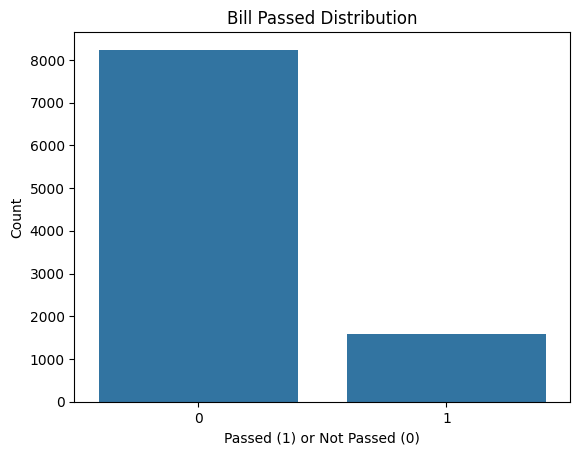

In [ ]:
# Count occurrences of each class in the target variable
print("\nTarget Variable Distribution:")
print(df["bill_passed"].value_counts())

# Visualize target variable distribution
sns.countplot(x=df["bill_passed"])
plt.title("Bill Passed Distribution")
plt.xlabel("Passed (1) or Not Passed (0)")
plt.ylabel("Count")
plt.show()

<Figure size 1200x600 with 0 Axes>

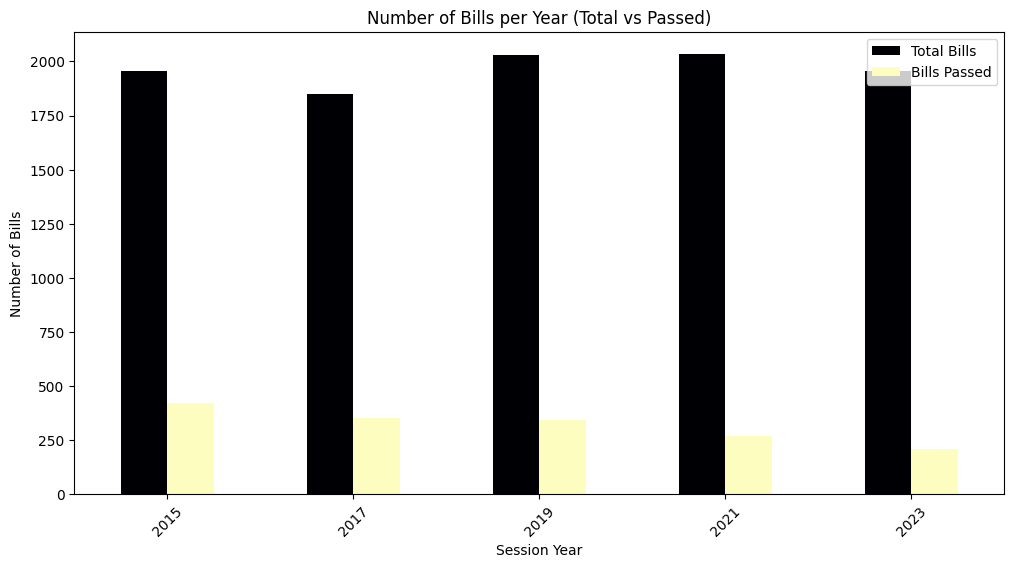

In [ ]:
## Plot Number of Rows Per Year

# Count occurrences per session year
session_year_counts = df['session_year'].value_counts().sort_index()
passed_counts = df[df['bill_passed'] == 1]['session_year'].value_counts().sort_index()

# Merge total and passed counts into a single dataframe
session_data = pd.DataFrame({'Total Bills': session_year_counts, 'Bills Passed': passed_counts}).fillna(0)

# Plot the number of rows per year
plt.figure(figsize=(12, 6))
session_data.plot(kind='bar', stacked=False, figsize=(12, 6), colormap="magma")
plt.xlabel("Session Year")
plt.ylabel("Number of Bills")
plt.title("Number of Bills per Year (Total vs Passed)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Count unique values per categorical column
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nUnique Values in Categorical Features:")
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")


Unique Values in Categorical Features:
bill_id: 15111 unique values
readable_bill_id: 4748 unique values
Bill Chamber: 2 unique values
Bill Type: 3 unique values
Local or Public Bill: 2 unique values
session_year: 13 unique values
sSummary: 2130 unique values
primary_sponsor_name: 366 unique values
primary_sponsor_party: 3 unique values
bill_status: 4 unique values
status_category: 6 unique values
status_date: 1169 unique values
last_action_date: 1257 unique values


# Preprocessing

## Handle Missing Data

In [ ]:
# Delete rows where "session_year" equals 2025, 2011, or invalid session years
df = df[~df['session_year'].isin(['2025', '2011', 'E1', 'E2', 'E3', 'E4', 'E5'])]

# Delete rows where "Bill Type" does not equal "B" (should result in 10421 rows)
if 'Bill Type' in df.columns:
    df = df[df['Bill Type'] == 'B']

# Delete rows where "primary_sponsor_name" is missing
df = df.dropna(subset=['primary_sponsor_name'])

# Drop rows where primary_sponsor_party is "Unknown"
df = df[df['primary_sponsor_party'] != "Unknown"]

# Drop rows where 'Bill Chamber' is not 'H' or 'S'
df = df[df['Bill Chamber'].isin(['H', 'S'])]

## Drop unneccessary columns and handle numeric conversions

In [ ]:
## Drop unnecessary columns
drop_columns = ['bill_id', 'readable_bill_id', 'Bill Number', 'Bill Type', 'Vote Type', 'nFiscalImpact', 'Short Title', 'in_ncga', 'bill_status', 'status_category', 'status_date', 'last_action_date', 'in_legiscan']
df.drop(columns=drop_columns, inplace=True, errors='ignore')

# Ignore Sponsor-Related Columns
drop_columns = ['primary_sponsor_name']
df.drop(columns=drop_columns, inplace=True, errors='ignore')

# Ignore Bill Category-Related Columns
drop_columns = ['bill_keywords']
df.drop(columns=drop_columns, inplace=True, errors='ignore')

## Convert Categorical Variables to Numeric

# Local or Public Bill: P = 0, L = 1
df['Local or Public Bill'] = df['Local or Public Bill'].map({'P': 0, 'L': 1})

# Bill Chamber: H = 0, S = 1
df['Bill Chamber'] = df['Bill Chamber'].map({'H': 0, 'S': 1})

# Primary Sponsor Party: D = 0, R = 1
df['primary_sponsor_party'] = df['primary_sponsor_party'].map({'D': 0, 'R': 1})

# Convert TRUE/FALSE values in 'bill_passed' to 0 or 1
df['bill_passed'] = df['bill_passed'].map({False: 0, True: 1})

# Convert TRUE/FALSE values in 'is_partisan' to 0 or 1
df['is_bipartisan'] = df['is_bipartisan'].map({False: 0, True: 1})

## <font color="red">Export Post-Processed Pre-Normalized Data</font>

In [ ]:
# prompt: Write a code to export the dataframe

# Export the DataFrame to a CSV file
df.to_csv('data_pre_partisan.csv', index=False)

# Download the CSV file from Google Colab
from google.colab import files
files.download('data_pre_partisan.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Correlation Analysis

Optional correlation analysis prior to feature engineering


Correlation with Target Variable:
bill_passed              1.000000
primary_sponsor_party    0.251258
nRollCall                0.106828
Local or Public Bill     0.101768
is_bipartisan            0.053494
nUncodified              0.021222
Bill Chamber            -0.010422
nStudies                -0.012214
nConstitution           -0.030981
nAppropriations         -0.180118
Name: bill_passed, dtype: float64


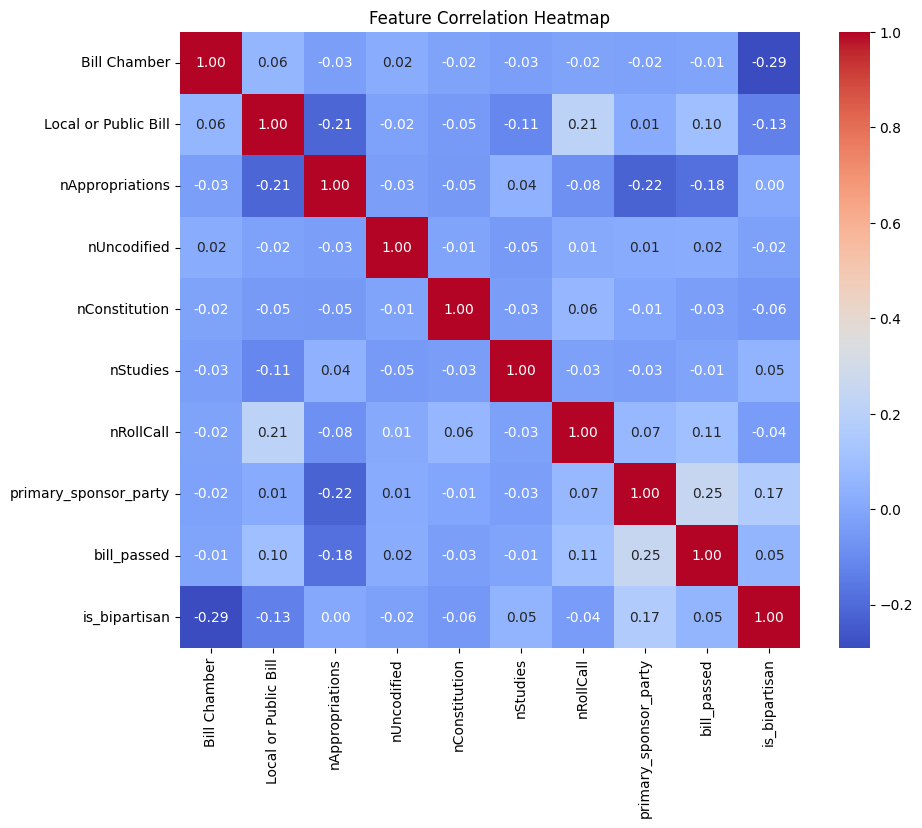

In [ ]:
# Ensure only numerical columns are used for correlation computation
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Display correlation with the target variable
if 'bill_passed' in correlation_matrix:
    print("\nCorrelation with Target Variable:")
    print(correlation_matrix["bill_passed"].sort_values(ascending=False))
else:
    print("\n'Bill Passed' column not found in numeric correlation matrix.")

# Visualize correlation matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Generate the correlation table

# Ensure only numerical columns are used for correlation computation
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation table
correlation_matrix

,Bill Chamber,Local or Public Bill,nAppropriations,nUncodified,nConstitution,nStudies,nRollCall,primary_sponsor_party,bill_passed,is_bipartisan
Bill Chamber,1.000000,0.057870,-0.030262,0.018461,-0.017102,-0.028916,-0.016070,-0.021203,-0.010422,-0.290934
Local or Public Bill,0.057870,1.000000,-0.212925,-0.020639,-0.045435,-0.111553,0.209913,0.011950,0.101768,-0.132992
nAppropriations,-0.030262,-0.212925,1.000000,-0.033445,-0.052224,0.044348,-0.080178,-0.222748,-0.180118,0.004177
nUncodified,0.018461,-0.020639,-0.033445,1.000000,-0.009990,-0.045536,0.007781,0.012957,0.021222,-0.024121
nConstitution,-0.017102,-0.045435,-0.052224,-0.009990,1.000000,-0.034597,0.064780,-0.008080,-0.030981,-0.055608
nStudies,-0.028916,-0.111553,0.044348,-0.045536,-0.034597,1.000000,-0.027814,-0.029438,-0.012214,0.047279
nRollCall,-0.016070,0.209913,-0.080178,0.007781,0.064780,-0.027814,1.000000,0.067609,0.106828,-0.041230
primary_sponsor_party,-0.021203,0.011950,-0.222748,0.012957,-0.008080,-0.029438,0.067609,1.000000,0.251258,0.165426
bill_passed,-0.010422,0.101768,-0.180118,0.021222,-0.030981,-0.012214,0.106828,0.251258,1.000000,0.053494
is_bipartisan,-0.290934,-0.132992,0.004177,-0.024121,-0.055608,0.047279,-0.041230,0.165426,0.053494,1.000000


# Feature Engineering

## Generate Partisan Ratio Column

Used to determine the level of partisanship of a bill. A ratio of 1 indicates partisan toward democrats.

In [ ]:
# ==========================
# 📺 Import Required Libraries
# ==========================
import pandas as pd
from google.colab import files

# ==========================
# 📺 Load the Dataset
# ==========================
df = pd.read_csv('data_pre_partisan.csv', quoting=0)

# ==========================
# 📺 Step 1: Add `dem_sponsor_count` and `rep_sponsor_count` into `total_sponsor_count`
# ==========================
df["total_sponsor_count"] = df["dem_sponsor_count"] + df["rep_sponsor_count"]

# ==========================
# 📺 Step 2: Calculate the Weighted Ratio of `dem_sponsor_count` Based on Max Possible Sponsors
# ==========================
# Define max sponsors based on Bill Chamber
df["max_sponsors"] = df["Bill Chamber"].apply(lambda x: 50 if x == 0 else 120)

# Compute weighted ratio
df["weighted_dem_ratio"] = df["dem_sponsor_count"] / df["max_sponsors"]
df["weighted_dem_ratio"] = df["weighted_dem_ratio"].fillna(0)  # Handle division by zero

# Ensure weighted_dem_ratio does not exceed 1
df["weighted_dem_ratio"] = df["weighted_dem_ratio"].clip(upper=1)

# ==========================
# 📺 Display First Few Rows
# ==========================
print("Processed Data Preview:")
print(df.head())

# ==========================
# 📺 Save Processed Data to CSV
# ==========================
output_file = "processed_legislative_data.csv"
df.to_csv(output_file, index=False)

print(f"Processed file saved as: {output_file}")

Processed Data Preview:
   Bill Chamber  Local or Public Bill  nAppropriations  nUncodified  \
0             0                     0                0            0   
1             0                     1                0            0   
2             0                     0                0            0   
3             0                     1                0            0   
4             0                     1                0            0   

   nConstitution  nStudies  nRollCall  session_year  \
0              1         0          0          2019   
1              0         0          1          2019   
2              0         0          0          2019   
3              0         0          0          2019   
4              0         0          1          2019   

                                            sSummary  \
0  House committee substitute to the 1st edition ...   
1  Names the act the "Seizure Safe Schools Act of...   
2  Part I.Amends GS 14-269, which prohibits carry.

# NLP Feature Extraction for Legislative Bill Summaries

Uses NLP techniques to extract the following additional features:
- ```simple_education_score```
- ```simple_healthcare_score```
- ```simple_taxation_score```
- ```simple_public_safety_score```
- ```simple_election_score```
- ```simple_transportation_score```
- ```simple_environment_score```
- ```simple_judiciary_score```
- ```simple_social_services_score```
- ```simple_economic_development_score```
- ```simple_primary_topic```
- ```simple_is_local```
- ```simple_is_statewide```
- ```simple_has_appropriation```

In [ ]:
# LLM Feature Extraction for Legislative Bill Summaries
# =====================================================

# Step 1: Install required libraries
!pip install openai transformers tqdm scikit-learn pandas numpy

# Step 2: Import libraries
import pandas as pd
import numpy as np
import json
import re
import time
import os
from tqdm.notebook import tqdm
import openai
from google.colab import files
from sklearn.impute import SimpleImputer

# Step 3: Upload your CSV file
#print("Please upload your CSV file with bill summaries...")
#uploaded = files.upload()

# Get the filename of the uploaded file
#file_name = list(uploaded.keys())[0]
#print(f"File uploaded: {file_name}")

# Step 4: Load the data
#df = pd.read_csv(file_name)
#print(f"Loaded {len(df)} rows with {len(df.columns)} columns")

# Display the first few rows to verify the data
print("\nFirst few rows:")
display(df.head())

# Verify the summary column exists
if 'sSummary' not in df.columns:
    print("ERROR: 'sSummary' column not found in the data.")
    available_columns = df.columns.tolist()
    print(f"Available columns: {available_columns}")
    # Try to find a similar column
    potential_summary_cols = [col for col in available_columns if 'summ' in col.lower()]
    if potential_summary_cols:
        print(f"Potential summary columns found: {potential_summary_cols}")
else:
    print(f"Summary column 'sSummary' found with {df['sSummary'].notna().sum()} non-null values")

# Step 5: Define feature extraction functions

def extract_llm_features_openai(df, summary_column, api_key, model="gpt-3.5-turbo", batch_size=5, max_rows=None):
    """
    Extract structured features from bill summaries using OpenAI API.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the bill summaries
    summary_column : str
        Name of the column containing the summaries
    api_key : str
        OpenAI API key
    model : str
        OpenAI model to use
    batch_size : int
        Number of summaries to process in each batch
    max_rows : int or None
        Maximum number of rows to process (for testing or budget constraints)

    Returns:
    --------
    pandas.DataFrame
        DataFrame with original data plus LLM-extracted features
    """
    # Initialize OpenAI client
    openai.api_key = api_key
    client = openai.OpenAI(api_key=api_key)

    # Create a copy of the dataframe to avoid modifying the original
    df_features = df.copy()

    # Limit rows if specified
    if max_rows is not None:
        df_process = df.head(max_rows).copy()
    else:
        df_process = df.copy()

    # Dictionary to store extracted features
    feature_dict = {
        'llm_primary_topic': [None] * len(df),
        'llm_scope': [None] * len(df),
        'llm_complexity_rating': [None] * len(df),
        'llm_fiscal_impact': [None] * len(df),
        'llm_stakeholders': [None] * len(df),
        'llm_implementation_timeframe': [None] * len(df),
        'llm_controversy_potential': [None] * len(df),
        'llm_bipartisan_appeal': [None] * len(df)
    }

    # Process in batches to handle API rate limits
    for i in tqdm(range(0, len(df_process), batch_size), desc="Processing batches"):
        batch = df_process.iloc[i:i+batch_size]

        for idx, row in batch.iterrows():
            summary = str(row[summary_column])
            if pd.isna(summary) or summary == "":
                continue

            # Limit summary length to avoid token limits
            if len(summary) > 8000:
                summary = summary[:8000] + "..."

            # Construct the prompt
            prompt = f"""
            Analyze this legislative bill summary and extract the following features in JSON format:

            1. primary_topic: The main policy area (choose one: education, healthcare, taxation, public_safety, election, transportation, environment, judiciary, social_services, economic_development, other)
            2. scope: Is this bill primarily "local", "statewide", or "unclear"
            3. complexity_rating: Rate from 1-5 (1=simple, 5=complex) based on technical language and scope
            4. fiscal_impact: Does this bill appear to have direct financial implications? Answer "yes", "no", or "unclear"
            5. stakeholders: List up to 3 main stakeholder groups affected (e.g., "schools", "businesses", "voters")
            6. implementation_timeframe: When does this appear to take effect? "immediate", "next_fiscal_year", "future_date", or "unclear"
            7. controversy_potential: Rate from 1-5 (1=non-controversial, 5=highly controversial)
            8. bipartisan_appeal: Rate from 1-5 (1=strongly partisan, 5=strong bipartisan appeal)

            Legislative Summary: {summary}

            Respond ONLY with a valid JSON object containing these fields.
            """

            try:
                # Call the OpenAI API
                response = client.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=0.0  # Keep deterministic
                )

                # Extract and parse the JSON response
                result_text = response.choices[0].message.content.strip()

                # Clean the response to ensure valid JSON
                result_text = re.sub(r'```json', '', result_text)
                result_text = re.sub(r'```', '', result_text)
                result_text = result_text.strip()

                result = json.loads(result_text)

                # Add the extracted features to our dictionary
                for key, value in result.items():
                    feature_key = f"llm_{key}"
                    if feature_key in feature_dict:
                        feature_dict[feature_key][idx] = value

                # Add a short delay to avoid rate limits
                time.sleep(0.5)

            except Exception as e:
                print(f"Error processing summary at index {idx}: {e}")
                # Try to save what we've extracted so far
                temp_df = df.copy()
                for key, values in feature_dict.items():
                    temp_df[key] = values
                temp_df.to_csv('llm_features_progress.csv', index=False)
                print(f"Saved progress to llm_features_progress.csv")
                time.sleep(2)  # Longer delay after an error

    # Add the extracted features to the dataframe
    for key, values in feature_dict.items():
        df_features[key] = values

    return df_features

def simple_feature_extraction(df, summary_column):
    """
    Extract simple text-based features without using an API.
    This is useful when you don't have an API key or want to avoid costs.
    """
    print("Extracting simple text-based features...")
    df_features = df.copy()

    # Define keyword lists for different policy areas
    policy_areas = {
        'education': ['school', 'education', 'student', 'teacher', 'classroom', 'curriculum'],
        'healthcare': ['health', 'medical', 'patient', 'hospital', 'disease', 'treatment', 'seizure'],
        'taxation': ['tax', 'revenue', 'fiscal', 'fund', 'budget'],
        'public_safety': ['weapon', 'firearm', 'handgun', 'concealed', 'criminal', 'offenses'],
        'election': ['election', 'vote', 'ballot', 'polling', 'voter'],
        'transportation': ['highway', 'road', 'vehicle', 'driver', 'transportation'],
        'environment': ['environment', 'pollution', 'conservation', 'wildlife'],
        'judiciary': ['court', 'judge', 'judicial', 'legal', 'criminal', 'civil'],
        'social_services': ['welfare', 'assistance', 'benefit', 'social service', 'community'],
        'economic_development': ['business', 'economic', 'development', 'commerce', 'industry']
    }

    # Initialize columns
    for area in policy_areas:
        df_features[f'simple_{area}_score'] = 0

    # Calculate scores for each policy area
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing summaries"):
        summary = str(row[summary_column]).lower()
        if pd.isna(summary) or summary == "":
            continue

        for area, keywords in policy_areas.items():
            score = sum(1 for keyword in keywords if keyword in summary)
            df_features.at[idx, f'simple_{area}_score'] = score

    # Determine the primary policy area
    area_columns = [f'simple_{area}_score' for area in policy_areas]
    df_features['simple_primary_topic'] = df_features[area_columns].idxmax(axis=1)
    df_features['simple_primary_topic'] = df_features['simple_primary_topic'].str.replace('simple_', '').str.replace('_score', '')

    # Extract other simple features
    df_features['simple_word_count'] = df_features[summary_column].fillna('').apply(lambda x: len(str(x).split()))
    df_features['simple_char_count'] = df_features[summary_column].fillna('').apply(lambda x: len(str(x)))

    # Check for local vs. statewide
    local_indicators = ['town of', 'city of', 'county of', 'local', 'municipal', 'village of']
    statewide_indicators = ['statewide', 'throughout the state', 'all counties', 'state board', 'general statutes']

    df_features['simple_is_local'] = df_features[summary_column].fillna('').apply(
        lambda x: any(indicator in str(x).lower() for indicator in local_indicators)
    )
    df_features['simple_is_statewide'] = df_features[summary_column].fillna('').apply(
        lambda x: any(indicator in str(x).lower() for indicator in statewide_indicators)
    )

    # Check for appropriations/fiscal impact
    df_features['simple_has_appropriation'] = df_features[summary_column].fillna('').apply(
        lambda x: 'appropriate' in str(x).lower() or 'fund' in str(x).lower()
    )

    # Check for complexity indicators
    technical_terms = ['pursuant to', 'henceforth', 'herein', 'thereof', 'set forth', 'shall', 'provisions of']
    df_features['simple_technical_term_count'] = df_features[summary_column].fillna('').apply(
        lambda x: sum(str(x).lower().count(term) for term in technical_terms)
    )

    # Extract GS references as a complexity indicator
    df_features['simple_gs_reference_count'] = df_features[summary_column].fillna('').apply(
        lambda x: len(re.findall(r'GS\s+\d+[A-Z]?-\d+', str(x)))
    )

    return df_features

# Step 6: Set up the feature extraction process

df_features = simple_feature_extraction(df, summary_column='sSummary')



First few rows:


,Bill Chamber,Local or Public Bill,nAppropriations,nUncodified,nConstitution,nStudies,nRollCall,session_year,sSummary,bill_keywords,...,primary_sponsor_party,cosponsor_count,dem_sponsor_count,rep_sponsor_count,other_sponsor_count,bill_passed,is_bipartisan,total_sponsor_count,max_sponsors,weighted_dem_ratio
0,0,0,0,0,1,0,0,2019,House committee substitute to the 1st edition ...,"CONSTITUTION, NC, ECONOMIC DEVELOPMENT, ELECTI...",...,1,13,2,12,0,0,1,14,50,0.04
1,0,1,0,0,0,0,1,2019,"Names the act the ""Seizure Safe Schools Act of...","ANNEXATION, COUNTIES, LOCAL, LOCAL GOVERNMENT,...",...,1,1,0,2,0,1,0,2,50,0.00
2,0,0,0,0,0,0,0,2019,"Part I.Amends GS 14-269, which prohibits carry...","DHHS, HEALTH SERVICES, INSURANCE, HEALTH, MEDI...",...,0,54,55,0,0,0,0,55,50,1.00
3,0,1,0,0,0,0,0,2019,House committee substitute to the 1st edition ...,"AIRPORTS, AUTHORITIES, AVIATION, CONTRACTS, CO...",...,1,1,0,2,0,1,0,2,50,0.00
4,0,1,0,0,0,0,1,2019,"Titles the act as the ""North Carolina Reclaimi...","AUTHORITIES, COUNTIES, HOTELS & MOTELS, LOCAL,...",...,1,0,0,1,0,0,0,1,50,0.00


Summary column 'sSummary' found with 9811 non-null values
Extracting simple text-based features...


Processing summaries:   0%|          | 0/9826 [00:00<?, ?it/s]

## Merge Dataframes

Merge the original dataframe and our NLP dataframe



In [ ]:
import pandas as pd
# Assuming 'df' and 'df_features' are your DataFrames

# Columns to merge from df_features
columns_to_merge = [
    'simple_education_score',
    'simple_healthcare_score',
    'simple_taxation_score',
    'simple_public_safety_score',
    'simple_election_score',
    'simple_transportation_score',
    'simple_environment_score',
    'simple_judiciary_score',
    'simple_social_services_score',
    'simple_economic_development_score',
    'simple_primary_topic',
    'simple_is_local',
    'simple_is_statewide',
    'simple_has_appropriation'
]

# Check if all columns exist in df_features before merging
missing_columns = set(columns_to_merge) - set(df_features.columns)
if missing_columns:
    print(f"Warning: The following columns are not present in df_features: {missing_columns}")
    # Decide how to handle missing columns (e.g., remove them from the merge list, or fill with defaults).
    columns_to_merge = list(set(columns_to_merge) - missing_columns)

# Merge the dataframes
df = pd.merge(df, df_features[columns_to_merge], left_index=True, right_index=True, how='left')

# Display or use the merged dataframe 'df'
print(df.head())


   Bill Chamber  Local or Public Bill  nAppropriations  nUncodified  \
0             0                     0                0            0   
1             0                     1                0            0   
2             0                     0                0            0   
3             0                     1                0            0   
4             0                     1                0            0   

   nConstitution  nStudies  nRollCall  session_year  \
0              1         0          0          2019   
1              0         0          1          2019   
2              0         0          0          2019   
3              0         0          0          2019   
4              0         0          1          2019   

                                            sSummary  \
0  House committee substitute to the 1st edition ...   
1  Names the act the "Seizure Safe Schools Act of...   
2  Part I.Amends GS 14-269, which prohibits carry...   
3  House committee

In [ ]:
# prompt: write a piece of code to save the dataframe and export it as a csv

# Assuming 'df' is your DataFrame
df.to_csv('final_processed_data.csv', index=False)
files.download('final_processed_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Handling Class Imbalance, Generate Model and Analyze Performance


Dataset shape: (9826, 35)

First few rows:
   Bill Chamber  Local or Public Bill  nAppropriations  nUncodified  \
0             0                     0                0            0   
1             0                     1                0            0   
2             0                     0                0            0   
3             0                     1                0            0   
4             0                     1                0            0   

   nConstitution  nStudies  nRollCall  session_year  \
0              1         0          0          2019   
1              0         0          1          2019   
2              0         0          0          2019   
3              0         0          0          2019   
4              0         0          1          2019   

                                            sSummary  \
0  House committee substitute to the 1st edition ...   
1  Names the act the "Seizure Safe Schools Act of...   
2  Part I.Amends GS 14-269, wh

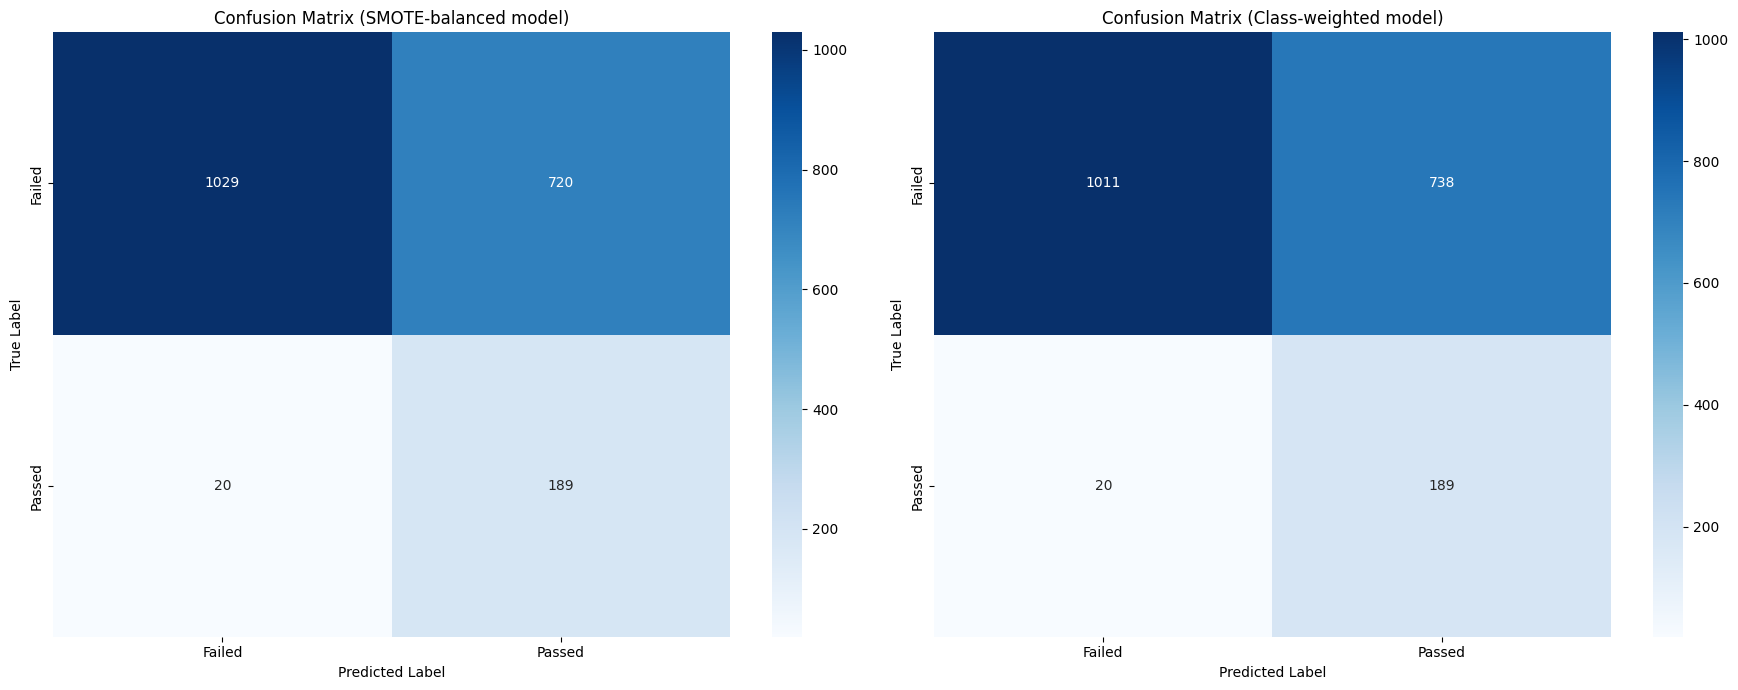


Based on AUC, the SMOTE-balanced model performs better.


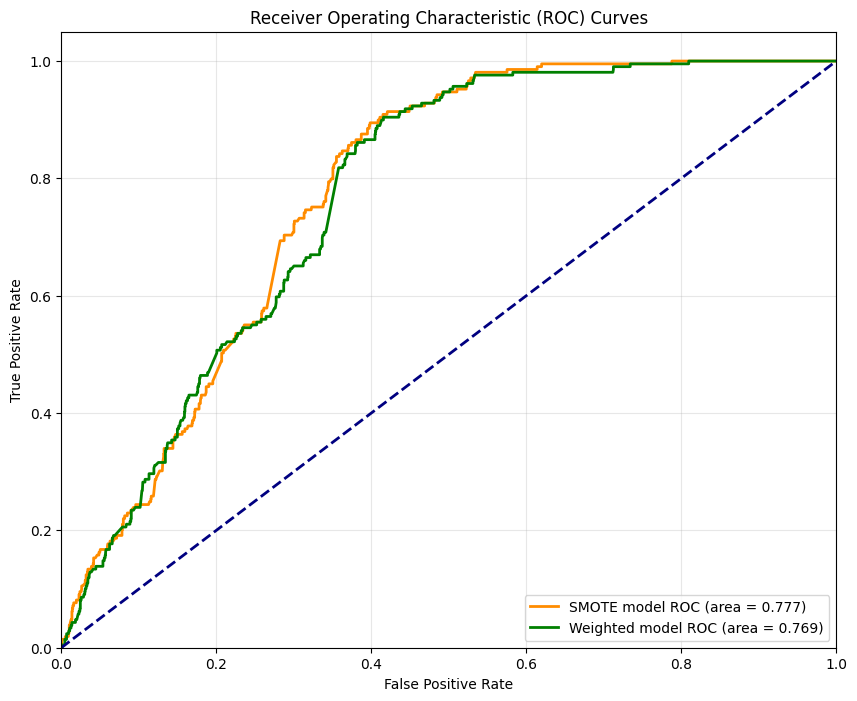

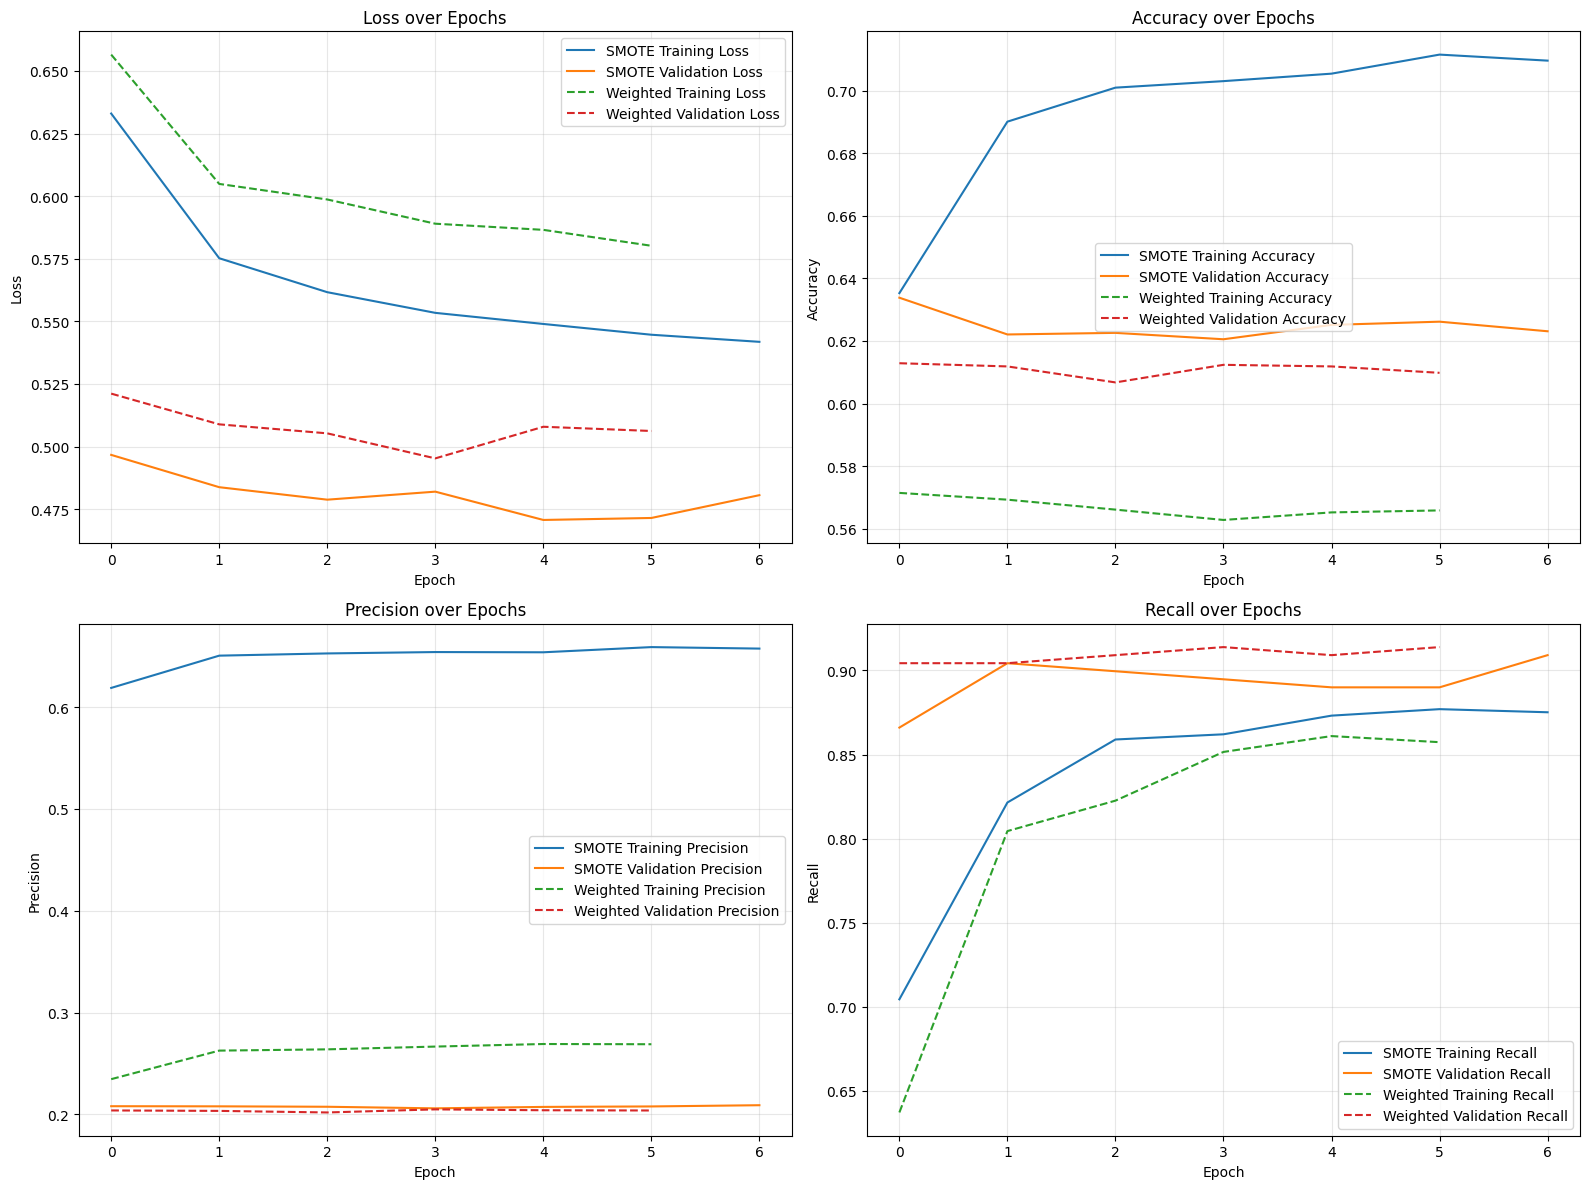


Calculating permutation importance for the SMOTE-balanced model...


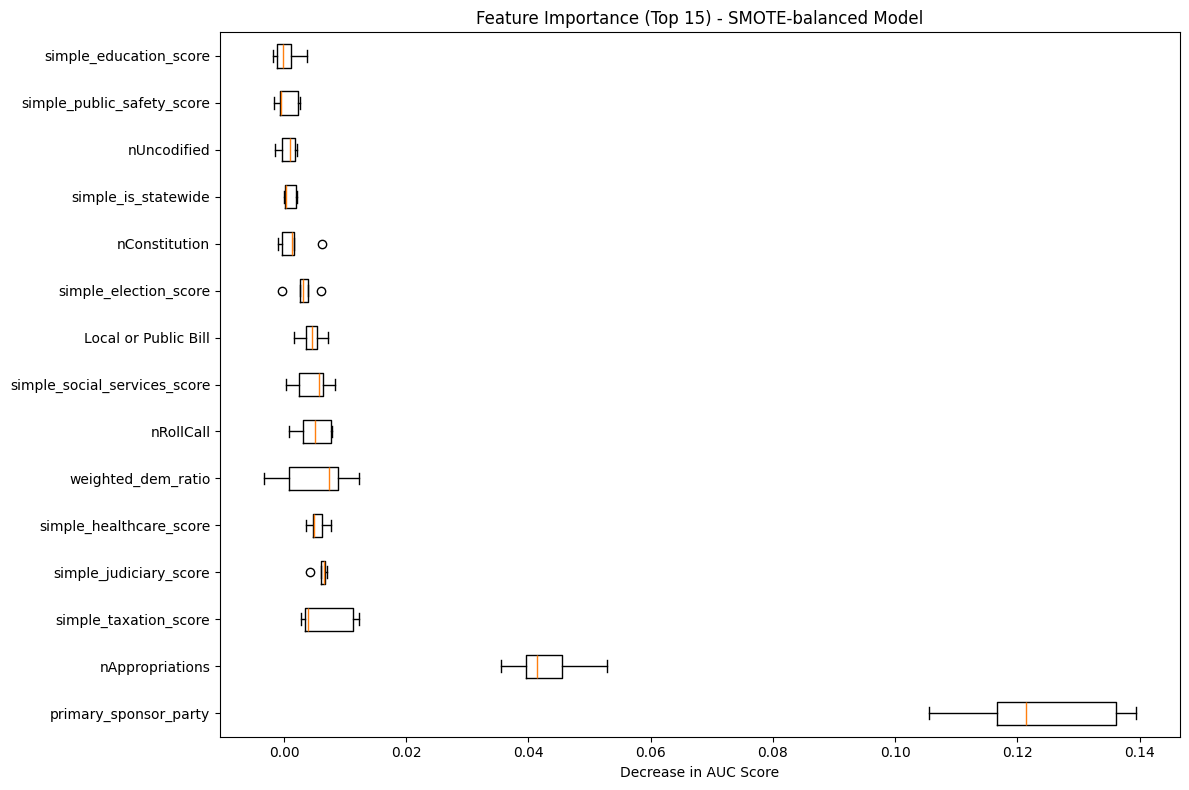


Feature Correlation with Target (Training Data):
bill_passed                          1.000000
primary_sponsor_party                0.242829
nRollCall                            0.107140
Local or Public Bill                 0.099588
is_bipartisan                        0.059957
simple_is_local                      0.028974
simple_education_score               0.014683
nUncodified                          0.009424
simple_economic_development_score    0.007018
simple_public_safety_score           0.005606
simple_environment_score             0.002939
simple_election_score                0.002747
simple_judiciary_score               0.000978
simple_transportation_score         -0.003005
simple_is_statewide                 -0.009585
nStudies                            -0.010517
Bill Chamber                        -0.012429
simple_healthcare_score             -0.024434
simple_has_appropriation            -0.026889
simple_social_services_score        -0.029497
simple_taxation_score         

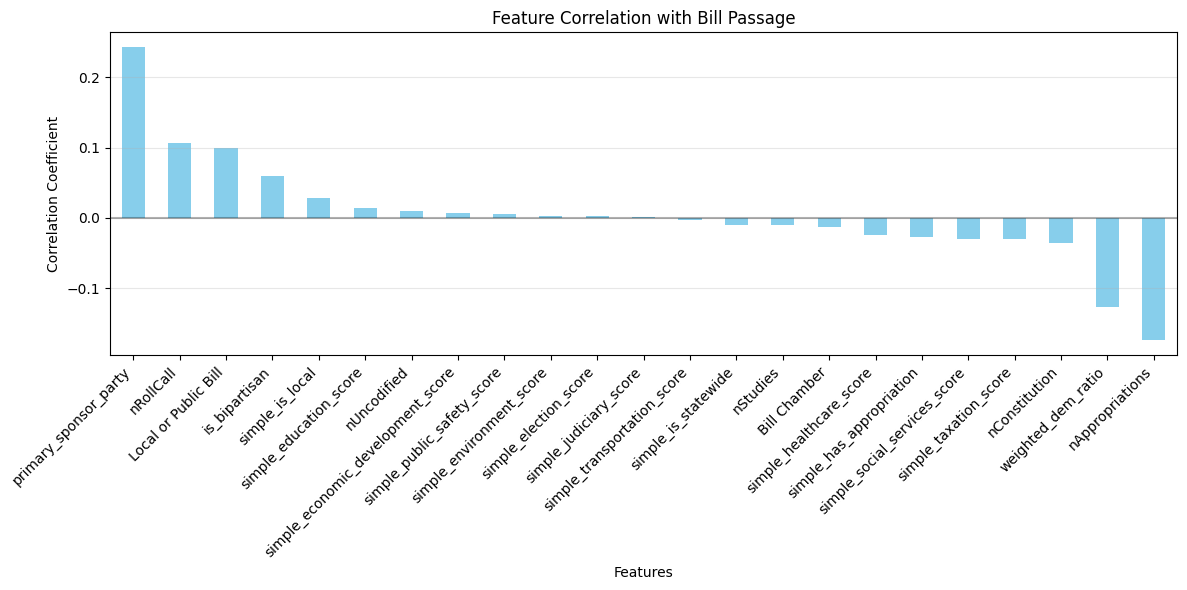


Optimal threshold for F1 score: 0.547 (F1: 0.348)
Default threshold (0.5) F1 score: 0.338


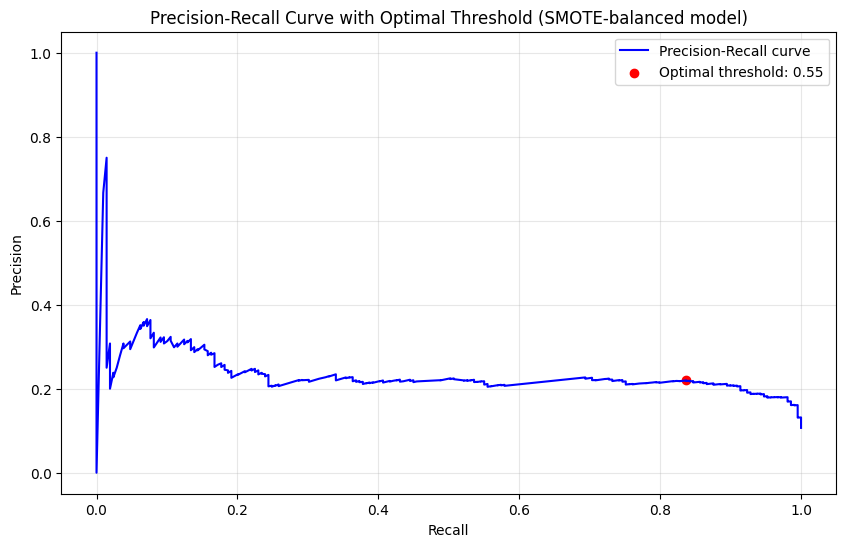


Classification Report with Optimized Threshold:
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1749
           1       0.22      0.84      0.35       209

    accuracy                           0.67      1958
   macro avg       0.60      0.74      0.56      1958
weighted avg       0.89      0.67      0.73      1958


Accuracy by Bill Chamber:
0: 0.6755
1: 0.6537


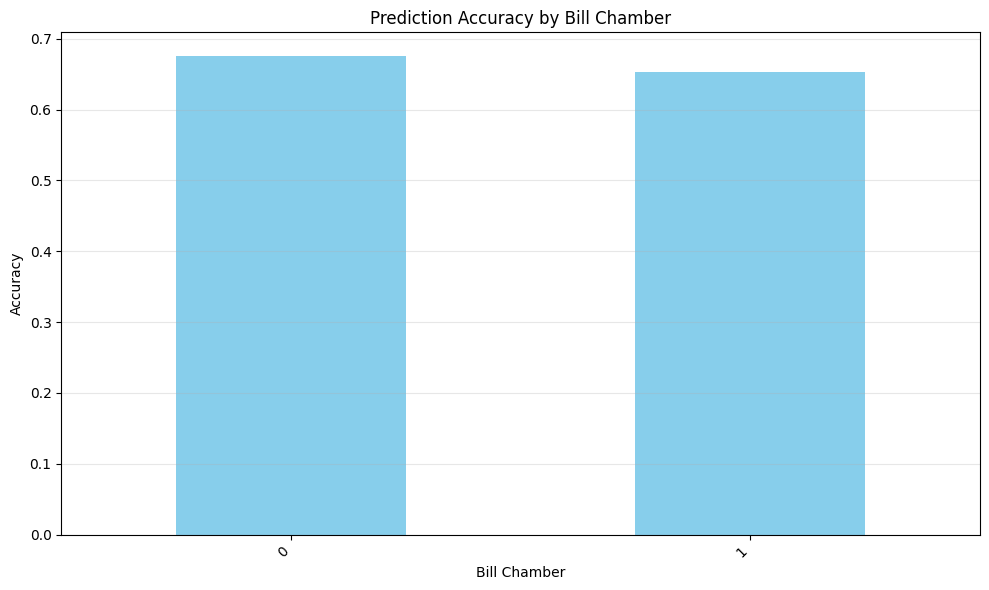


Accuracy by primary_sponsor_party:
0: 0.9914
1: 0.4321


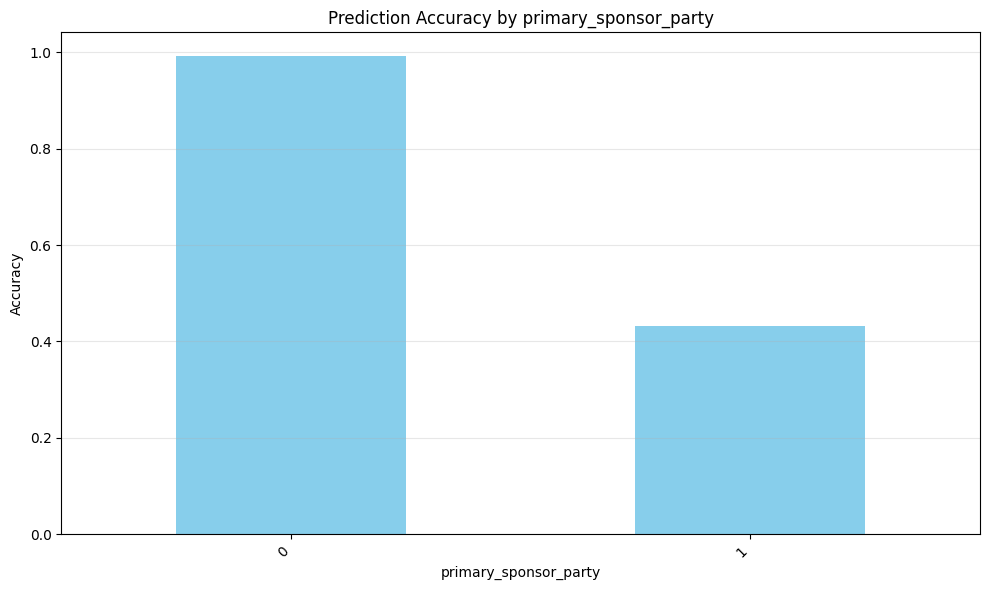


Accuracy by is_bipartisan:
0: 0.7131
1: 0.5817


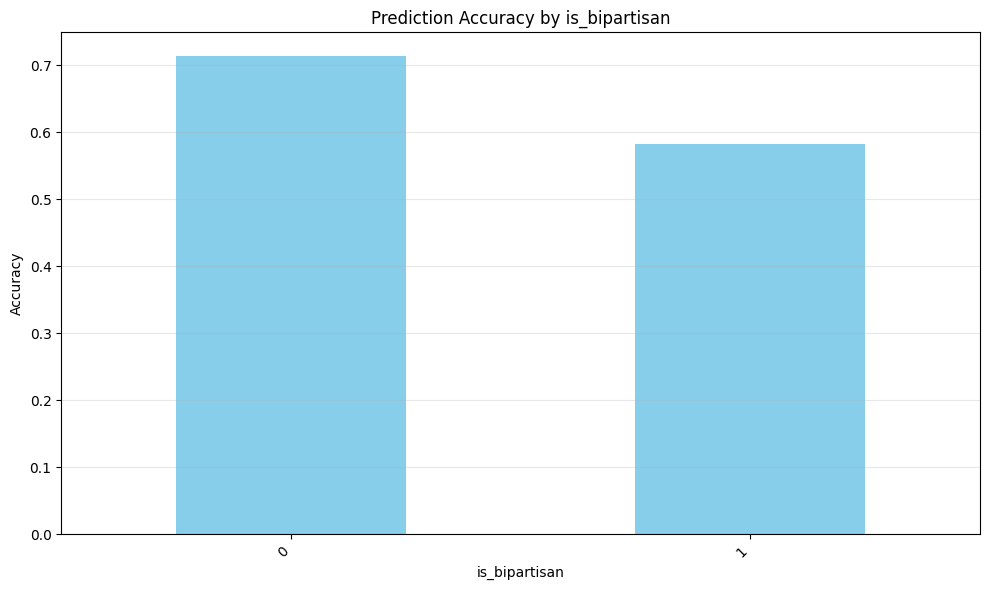


Accuracy by simple_has_appropriation:
True: 0.8190
False: 0.5474


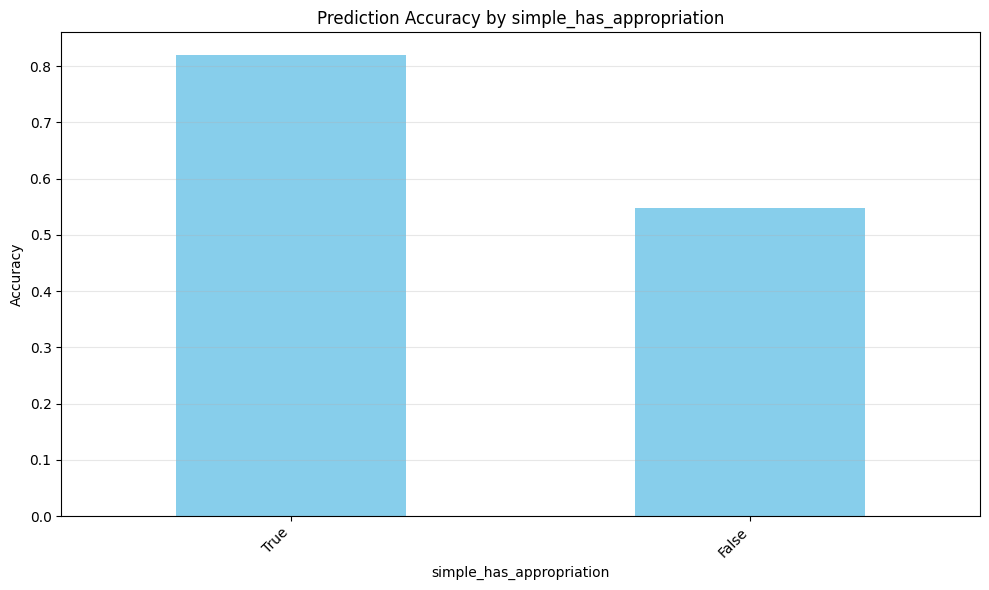


Accuracy by scope:
Both: 0.7805
Statewide: 0.7652
Other: 0.6589
Local: 0.6256


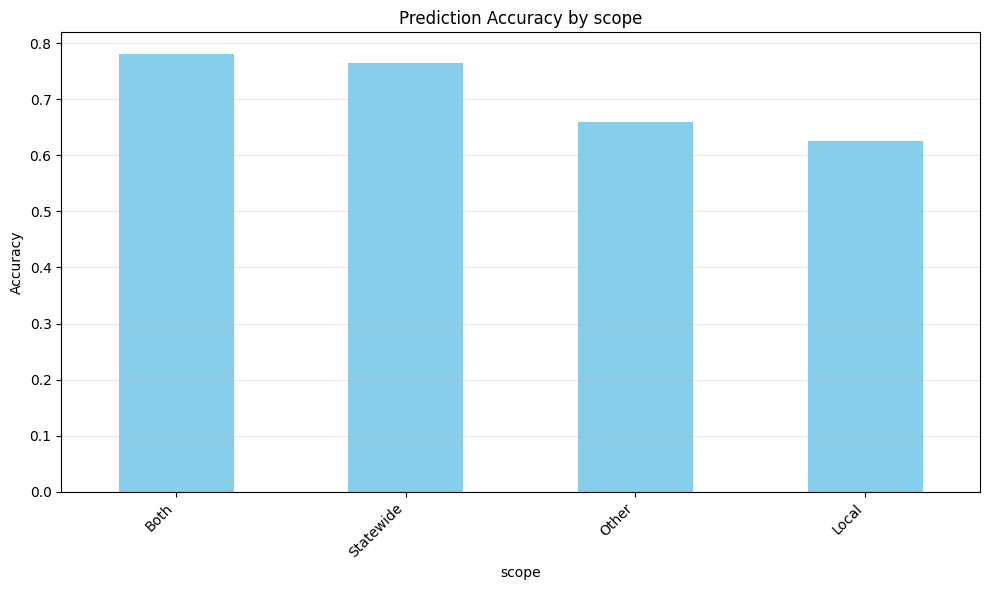


SMOTE-balanced Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,949 (42.77 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,300 (28.52 KB)


Class-weighted Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,325 (157.52 KB)

 Trainable params: 13,441 (52.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,884 (105.02 KB)


===== FINAL RESULTS =====
Best model: SMOTE-balanced
AUC Score: 0.7767
Using optimized threshold of 0.547 instead of 0.5:
Accuracy: 0.6655
F1 Score: 0.3483

Analysis complete!
Model saved to 'bill_passage_model.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model ready for download


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

print("\nDataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Define the features to use based on the requirements
feature_columns = [
    'Bill Chamber',
    'Local or Public Bill',
    'nAppropriations',
    'nUncodified',
    'nConstitution',
    'nStudies',
    'nRollCall',
    # 'session_year',
    'weighted_dem_ratio',
    'primary_sponsor_party',
    'is_bipartisan',
    'simple_education_score',
    'simple_healthcare_score',
    'simple_taxation_score',
    'simple_public_safety_score',
    'simple_election_score',
    'simple_transportation_score',
    'simple_environment_score',
    'simple_judiciary_score',
    'simple_social_services_score',
    'simple_economic_development_score',
    # 'simple_primary_topic',  # Commented out as specified
    'simple_is_local',
    'simple_is_statewide',
    'simple_has_appropriation'
]

# Check for missing values
print("\nMissing values in selected features:")
print(df[feature_columns + ['bill_passed', 'session_year']].isnull().sum())

# Fill missing values if any
for col in feature_columns:
    if df[col].dtype == np.number:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Handle missing values in target variable if any
df['bill_passed'] = df['bill_passed'].fillna(0)

# Split data into training and testing sets based on session_year
X_train = df[df['session_year'] != 2023][feature_columns]
y_train = df[df['session_year'] != 2023]['bill_passed']
X_test = df[df['session_year'] == 2023][feature_columns]
y_test = df[df['session_year'] == 2023]['bill_passed']

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Check class balance in training and test sets
print(f"\nTraining set class distribution: {np.bincount(y_train.astype(int))}")
print(f"Testing set class distribution: {np.bincount(y_test.astype(int))}")

# Identify numerical and categorical columns
numerical_cols = [col for col in feature_columns if col not in ['simple_is_local', 'simple_is_statewide', 'simple_has_appropriation']]
boolean_cols = ['simple_is_local', 'simple_is_statewide', 'simple_has_appropriation']

# Convert boolean columns (which may be stored as strings) to actual booleans
for col in boolean_cols:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].map({'True': 1, 'False': 0})
        X_test[col] = X_test[col].map({'True': 1, 'False': 0})
    numerical_cols.append(col)

print("\nNumerical columns:", numerical_cols)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ]
)

# Fit and transform the training data
print("\nApplying preprocessing transformations...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# If X_train_processed is sparse, convert to dense
if hasattr(X_train_processed, "toarray"):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")

# 4. Handle class imbalance

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"\nClass weights to handle imbalance: {class_weight_dict}")

# Apply SMOTE to balance the training data
print("\nApplying SMOTE to balance the training data...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(f"Original training set shape: {X_train_processed.shape}")
print(f"Resampled training set shape: {X_train_smote.shape}")
print(f"Original class distribution: {np.bincount(y_train.astype(int))}")
print(f"Resampled class distribution: {np.bincount(y_train_smote.astype(int))}")

# 5. Define the model as specified
print("\nDefining the model...")
model = Sequential([
    keras.Input(shape=(X_train_processed.shape[1],)),  # Explicit input layer
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with appropriate metrics for imbalanced data
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_auc',  # Monitor AUC instead of loss for imbalanced data
    patience=5,
    mode='max',  # We want to maximize AUC
    restore_best_weights=True
)

# 6. Train the model
print("\nTraining the model with SMOTE-balanced data...")
history_smote = model.fit(
    X_train_smote, y_train_smote,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_processed, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Train another model with class weights instead of SMOTE
print("\nTraining another model with class weights...")
model_weighted = Sequential([
    keras.Input(shape=(X_train_processed.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_weighted.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

history_weighted = model_weighted.fit(
    X_train_processed, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_processed, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

# 7. Evaluate the SMOTE-balanced model
print("\nEvaluating the SMOTE-balanced model...")
smote_loss, smote_accuracy, smote_precision, smote_recall, smote_auc = model.evaluate(X_test_processed, y_test)
print(f"Test Loss: {smote_loss:.4f}")
print(f"Test Accuracy: {smote_accuracy:.4f}")
print(f"Test Precision: {smote_precision:.4f}")
print(f"Test Recall: {smote_recall:.4f}")
print(f"Test AUC: {smote_auc:.4f}")

# Evaluate the class-weighted model
print("\nEvaluating the class-weighted model...")
weighted_loss, weighted_accuracy, weighted_precision, weighted_recall, weighted_auc = model_weighted.evaluate(X_test_processed, y_test)
print(f"Test Loss: {weighted_loss:.4f}")
print(f"Test Accuracy: {weighted_accuracy:.4f}")
print(f"Test Precision: {weighted_precision:.4f}")
print(f"Test Recall: {weighted_recall:.4f}")
print(f"Test AUC: {weighted_auc:.4f}")

# 8. Make predictions with both models
y_pred_proba_smote = model.predict(X_test_processed)
y_pred_smote = (y_pred_proba_smote > 0.5).astype(int)

y_pred_proba_weighted = model_weighted.predict(X_test_processed)
y_pred_weighted = (y_pred_proba_weighted > 0.5).astype(int)

# 9. Print classification reports
print("\nClassification Report (SMOTE-balanced model):")
print(classification_report(y_test, y_pred_smote))

print("\nClassification Report (Class-weighted model):")
print(classification_report(y_test, y_pred_weighted))

# 10. Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# SMOTE model confusion matrix
cm_smote = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Failed', 'Passed'],
            yticklabels=['Failed', 'Passed'])
axes[0].set_title('Confusion Matrix (SMOTE-balanced model)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Class-weighted model confusion matrix
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Failed', 'Passed'],
            yticklabels=['Failed', 'Passed'])
axes[1].set_title('Confusion Matrix (Class-weighted model)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Find the better model based on AUC
better_model = model if smote_auc > weighted_auc else model_weighted
better_y_pred = y_pred_smote if smote_auc > weighted_auc else y_pred_weighted
better_y_pred_proba = y_pred_proba_smote if smote_auc > weighted_auc else y_pred_proba_weighted
better_method = "SMOTE-balanced" if smote_auc > weighted_auc else "Class-weighted"
print(f"\nBased on AUC, the {better_method} model performs better.")

# 11. Plot ROC curves for both models
plt.figure(figsize=(10, 8))

# SMOTE model ROC
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)
roc_auc_smote = auc(fpr_smote, tpr_smote)
plt.plot(fpr_smote, tpr_smote, color='darkorange', lw=2,
         label=f'SMOTE model ROC (area = {roc_auc_smote:.3f})')

# Class-weighted model ROC
fpr_weighted, tpr_weighted, _ = roc_curve(y_test, y_pred_proba_weighted)
roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
plt.plot(fpr_weighted, tpr_weighted, color='green', lw=2,
         label=f'Weighted model ROC (area = {roc_auc_weighted:.3f})')

# Reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# 12. Plot training history metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history_smote.history['loss'], label='SMOTE Training Loss')
axes[0, 0].plot(history_smote.history['val_loss'], label='SMOTE Validation Loss')
axes[0, 0].plot(history_weighted.history['loss'], label='Weighted Training Loss', linestyle='--')
axes[0, 0].plot(history_weighted.history['val_loss'], label='Weighted Validation Loss', linestyle='--')
axes[0, 0].set_title('Loss over Epochs')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history_smote.history['accuracy'], label='SMOTE Training Accuracy')
axes[0, 1].plot(history_smote.history['val_accuracy'], label='SMOTE Validation Accuracy')
axes[0, 1].plot(history_weighted.history['accuracy'], label='Weighted Training Accuracy', linestyle='--')
axes[0, 1].plot(history_weighted.history['val_accuracy'], label='Weighted Validation Accuracy', linestyle='--')
axes[0, 1].set_title('Accuracy over Epochs')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history_smote.history['precision'], label='SMOTE Training Precision')
axes[1, 0].plot(history_smote.history['val_precision'], label='SMOTE Validation Precision')
axes[1, 0].plot(history_weighted.history['precision'], label='Weighted Training Precision', linestyle='--')
axes[1, 0].plot(history_weighted.history['val_precision'], label='Weighted Validation Precision', linestyle='--')
axes[1, 0].set_title('Precision over Epochs')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history_smote.history['recall'], label='SMOTE Training Recall')
axes[1, 1].plot(history_smote.history['val_recall'], label='SMOTE Validation Recall')
axes[1, 1].plot(history_weighted.history['recall'], label='Weighted Training Recall', linestyle='--')
axes[1, 1].plot(history_weighted.history['val_recall'], label='Weighted Validation Recall', linestyle='--')
axes[1, 1].set_title('Recall over Epochs')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 13. Feature importance analysis
# Define a function to calculate permutation importance for our neural network model
def get_permutation_importance(model, X, y):
    def nn_score(X, y):
        return model.evaluate(X, y, verbose=0)[4]  # Return AUC metric (index 4 in our metrics)

    # Added _ to capture and ignore the unused estimator argument
    result = permutation_importance(
        estimator=model,
        X=X,
        y=y,
        scoring=lambda estimator_, X_, y_: nn_score(X_, y_), # Use a lambda function to pass only X and y to nn_score
        n_repeats=5,
        random_state=42
    )
    return result

# Get feature names after preprocessing
feature_names = numerical_cols.copy()

# Calculate permutation importance for the better model
print(f"\nCalculating permutation importance for the {better_method} model...")
perm_importance = get_permutation_importance(better_model, X_test_processed, y_test)

# Sort features by importance
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_n = min(15, len(sorted_idx))  # Show top 15 features or all if fewer

# Plot feature importance
plt.figure(figsize=(12, 8))
sorted_idx = sorted_idx[:top_n]
plt.boxplot([perm_importance.importances[i] for i in sorted_idx],
            vert=False, labels=[feature_names[i] if i < len(feature_names) else f"Feature_{i}" for i in sorted_idx])
plt.title(f"Feature Importance (Top {top_n}) - {better_method} Model")
plt.xlabel("Decrease in AUC Score")
plt.tight_layout()
plt.show()

# Also analyze the correlation for numerical features
print("\nFeature Correlation with Target (Training Data):")
combined_df = pd.DataFrame()

# Use numerical features for this analysis
for col in numerical_cols:
    combined_df[col] = X_train[col]

combined_df['bill_passed'] = y_train

# Calculate correlations
correlations = combined_df.corr()['bill_passed'].sort_values(ascending=False)
print(correlations)

# Plot correlations
plt.figure(figsize=(12, 6))
correlations.drop('bill_passed').plot(kind='bar', color='skyblue')
plt.title('Feature Correlation with Bill Passage')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 14. Threshold optimization for imbalanced classes
# Find optimal threshold to balance precision and recall
precisions, recalls, thresholds = precision_recall_curve(y_test, better_y_pred_proba)

# Calculate F1 score for each threshold
f1_scores = [f1_score(y_test, (better_y_pred_proba >= t).astype(int)) for t in thresholds]
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"\nOptimal threshold for F1 score: {best_threshold:.3f} (F1: {best_f1:.3f})")
print(f"Default threshold (0.5) F1 score: {f1_score(y_test, better_y_pred):.3f}")

# Plot precision-recall curve with optimal threshold
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', label='Precision-Recall curve')
plt.scatter(recalls[best_threshold_idx], precisions[best_threshold_idx], marker='o', color='red',
           label=f'Optimal threshold: {best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve with Optimal Threshold ({better_method} model)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 15. Final classification report with optimized threshold
y_pred_optimized = (better_y_pred_proba >= best_threshold).astype(int)
print("\nClassification Report with Optimized Threshold:")
print(classification_report(y_test, y_pred_optimized))

# 16. Analyze bill passage by different categories
test_df = df[df['session_year'] == 2023].copy()
test_df['predicted'] = better_y_pred
test_df['predicted_optimized'] = y_pred_optimized
test_df['correct_prediction'] = test_df['predicted_optimized'] == test_df['bill_passed']

# Accuracy by different categories
def analyze_by_category(df, column):
    if column not in df.columns:
        print(f"Column {column} not found in dataframe.")
        return

    # Skip if the column has only one unique value
    if df[column].nunique() <= 1:
        print(f"Column {column} has only one unique value. Skipping analysis.")
        return

    accuracy_by_category = df.groupby(column)['correct_prediction'].mean().sort_values(ascending=False)

    print(f"\nAccuracy by {column}:")
    for category, accuracy in accuracy_by_category.items():
        print(f"{category}: {accuracy:.4f}")

    # Plot
    plt.figure(figsize=(10, 6))
    accuracy_by_category.plot(kind='bar', color='skyblue')
    plt.title(f'Prediction Accuracy by {column}')
    plt.ylabel('Accuracy')
    plt.xlabel(column)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return accuracy_by_category

# Analyze by various categories
categories_to_analyze = [
    'Bill Chamber',
    'primary_sponsor_party',
    'is_bipartisan',
    'simple_has_appropriation'
]

for category in categories_to_analyze:
    analyze_by_category(test_df, category)

# Create a scope category from is_local and is_statewide
test_df['scope'] = 'Other'
if 'simple_is_local' in test_df.columns and 'simple_is_statewide' in test_df.columns:
    test_df.loc[test_df['simple_is_local'] == 1, 'scope'] = 'Local'
    test_df.loc[test_df['simple_is_statewide'] == 1, 'scope'] = 'Statewide'
    test_df.loc[(test_df['simple_is_local'] == 1) & (test_df['simple_is_statewide'] == 1), 'scope'] = 'Both'

analyze_by_category(test_df, 'scope')

# 17. Final model summaries and results
print("\nSMOTE-balanced Model Summary:")
model.summary()

print("\nClass-weighted Model Summary:")
model_weighted.summary()

print("\n===== FINAL RESULTS =====")
print(f"Best model: {better_method}")
print(f"AUC Score: {max(smote_auc, weighted_auc):.4f}")
print(f"Using optimized threshold of {best_threshold:.3f} instead of 0.5:")
print(f"Accuracy: {(y_pred_optimized.flatten() == y_test).mean():.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimized):.4f}")
print("\nAnalysis complete!")

# Optional: Save the better model for future use
better_model.save('bill_passage_model.h5')
print("Model saved to 'bill_passage_model.h5'")

# Download the model if in Colab
try:
    from google.colab import files
    files.download('bill_passage_model.h5')
    print("Model ready for download")
except:
    print("Model saved as 'bill_passage_model.h5'")